# LLM Baseline Project
#*# I guess I'm building my highlight reel. I guess it's a deep fake of my best work. Knowledge is power, so let's retain what I've got as an LLM.
#!# take out used_tts from summary functions
#!# tts needs to be its own function?
#!# coefficients need to go on the other side of the summaries. params after that.
#!# function names are too long.
#!# check defaults because they need to be divine based on what I'm looking for.

#### Other Changes
* simupter should have a strategy='auto'. Then it can look for a 0.80 correlation or higher and build a linear model. Since I have stepwise built, it would be interesting to have that **build a stepwise lm, pass it through train-test split, and accept or fail to reject the missing value imputation strategy.** KNN imputer might also be a good idea if I can develop a little in terms of KNN optimization.
* catcoder would be awesome if it also worked with interval data. I want to implement **interval end truncation** for small sample sizes. This can maybe be called **grouper**.
* This **grouper** idea requires a quick analysis of the data. It needs to be able to identify interval, categorical, and binary data. Then, many of the functions are in place to prep things appropriately and develop optimal models. I wonder how an LLM of all of teaching materials would do. 
* regularization of linear models should be automatic. There should be an option to regularize. **Maybe the option should be called optimize**.
* perhaps yj_transformer should be more selective.
* I kind of want to build a faster hp tuning module for tree models. Still refining my idea as the value counts will take up the most time. I think it would be interesting to start with value counts per lean feature first (limited ranges, such as 0/1; 1,2,3,4,5; etc.). This can be done with len(pd.unique()) and running value counts on the results (ascending). It will probably look something like this:

In [1]:
# importing libraries
import pandas as pd                   # data science essentials
import matplotlib.pyplot as plt       # essential graphical output
import seaborn as sns                 # enhanced graphical output
import numpy as np                    # mathematical essentials
import statsmodels.formula.api as smf # regression modeling
import warnings                       # warnings


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# suppressing warnings
warnings.filterwarnings(action = 'ignore')


# specifying file path
file = './datasets/ames_transformed.xlsx'


# reading the file into Python
housing = pd.read_excel(io     = file,
                        header = 0   )

# importing interval and count data
file = './datasets/ames_non_continuous.xlsx'

housing_2 = pd.read_excel(io         = file,
                          header     = 0,
                          sheet_name = 'categorical_discrete')


# documentation: help(pd.DataFrame.merge)

# merging the two datasets
housing = housing.merge(right = housing_2,
                        on    = 'property_id',
                        how   = 'left')


# checking results
housing.head(n = 5)

,property_id,Lot_Area,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Garage_Area,Porch_Area,Sale_Price,m_Lot_Area,m_Mas_Vnr_Area,m_Second_Flr_SF,log_Sale_Price,log_Lot_Area,log_Gr_Liv_Area,Street,Lot_Config,Neighborhood
0,1,31770,112.0,1080,1656.0,0.0,1656,528.0,272,215000,0,0,0,12.278398,10.366309,7.412764,Pave,Corner,NAmes
1,2,11622,0.0,882,896.0,0.0,896,730.0,260,105000,0,0,0,11.561725,9.360741,6.799056,Pave,Inside,NAmes
2,3,14267,108.0,1329,1329.0,0.0,1329,312.0,429,172000,0,0,0,12.055256,9.565775,7.192934,Pave,Corner,NAmes
3,4,11160,0.0,2110,2110.0,0.0,2110,522.0,0,244000,0,1,0,12.404928,9.320181,7.654917,Pave,Corner,NAmes
4,5,13830,0.0,928,928.0,701.0,1629,482.0,246,189900,0,0,0,12.154258,9.534668,7.396335,Pave,Inside,Gilbert


In [2]:
from baserush import preprocess
from baserush import summary
from baserush import optimize

In [3]:
help(preprocess.simputer)

Help on function simputer in module baserush.preprocess:

simputer(df: 'ArrayLike', include: 'Optional[Sequence[str]]' = None, strategy: 'str' = 'mean', fill_value: 'Optional[Any]' = None, add_indicator: 'bool' = False, return_imputer: 'bool' = False) -> 'Union[pd.DataFrame, Tuple[pd.DataFrame, SimpleImputer]]'
    Imputes missing values on numeric columns (default: mean). Strategies
    include: 'mean'|'median'|'most_frequent'|'constant'.

    PARAMETERS
    ----------
    df             | DataFrame | data to be imputed            | No default.
    include        | list-like | features to impute            | Default = None
    strategy       | str       | imputation strategy to apply  | Default = "mean"
    fill_value     | numeric   | fill for strategy='constant'  | Default = None
    flag_feature   | bool      | binary flag identifying an    | Default = False
                   |           | originally missing value      |
    return_imputer | bool      | returns fitted imputer obje

In [4]:
# simputer
housing2 = preprocess.simputer(df         = housing,
                               strategy   = 'mean',
                               fill_value = -1000)

In [5]:
help(preprocess.catcoder)

Help on function catcoder in module baserush.preprocess:

catcoder(data: 'ArrayLike', min_samples: 'int' = 100, drop_most: 'bool' = False) -> 'pd.DataFrame'
    Encodes categorical features for use in machine learning models.

    PARAMETERS
    ----------
    data          | DF|Series | feature(s) to be categorically encoded  | No default.
    min_samples   | numeric   | minimum samples required for each new   | Default = 100
                              | categorical feature.                    |
    drop_most     | bool      | drops most frequent categorical feature | Default = False

    RETURNS
    -------
    A DataFrame containing categorically-encoded features.



In [6]:
# catcoder
cat_data = preprocess.catcoder(data        = housing2[ ['Lot_Config', 'Street', 'Neighborhood'] ],
                               min_samples = 100,
                               drop_most   = True)

housing3 = pd.concat(objs = [housing2, cat_data], axis = 1)
housing3.drop(labels = ['Street', 'Lot_Config', 'Neighborhood'],
              axis = 1,
              inplace = True)


print(housing3.shape)
housing3.head(n = 5)

(2930, 31)


,property_id,Lot_Area,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Garage_Area,Porch_Area,Sale_Price,m_Lot_Area,m_Mas_Vnr_Area,m_Second_Flr_SF,log_Sale_Price,log_Lot_Area,log_Gr_Liv_Area,Lot_Config_Corner,Lot_Config_CulDSac,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst
0,1,31770,112.0,1080,1656.0,0.0,1656,528.0,272,215000,0,0,0,12.278398,10.366309,7.412764,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,11622,0.0,882,896.0,0.0,896,730.0,260,105000,0,0,0,11.561725,9.360741,6.799056,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,14267,108.0,1329,1329.0,0.0,1329,312.0,429,172000,0,0,0,12.055256,9.565775,7.192934,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,11160,0.0,2110,2110.0,0.0,2110,522.0,0,244000,0,1,0,12.404928,9.320181,7.654917,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,13830,0.0,928,928.0,701.0,1629,482.0,246,189900,0,0,0,12.154258,9.534668,7.396335,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [7]:
help(preprocess.simple_scaler)

Help on function simple_scaler in module baserush.preprocess:

simple_scaler(df: 'ArrayLike', include: 'Optional[Sequence[str]]' = None, with_mean: 'bool' = True, with_std: 'bool' = True, copy: 'bool' = True, return_scaler: 'bool' = False) -> 'Union[pd.DataFrame, Tuple[pd.DataFrame, StandardScaler]]'
    Standardizes a dataset (μ = 0, σ² = 1).
    Requires sklearn.preprocessing.StandardScaler()

    PARAMETERS
    ----------
    df            | DataFrame  | data to be used for scaling  | No default.
    include       | list-like  | features to scale            | Default = None
    with_mean     | bool       | scale w/ feature means       | Default = True
    with_std      | bool       | scale w/ standard deviations | Default = True
    copy          | bool       | features to scale            | Default = True
    return_scaler | bool       | returns fitted scaler object | Default = False

    RETURNS
    -------
    DataFrame (and optionally fitted scaler object)



In [8]:
# standard_scaler
housing4 = preprocess.simple_scaler(df            = housing3,
                                    #include       = ['Sale_Price', 'Mas_Vnr_Area'],
                                    with_mean     = True,
                                    with_std      = True,
                                    return_scaler = False)

housing4

,property_id,Lot_Area,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Garage_Area,Porch_Area,Sale_Price,m_Lot_Area,m_Mas_Vnr_Area,m_Second_Flr_SF,log_Sale_Price,log_Lot_Area,log_Gr_Liv_Area,Lot_Config_Corner,Lot_Config_CulDSac,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst
0,-1.731460,2.751017,0.068434,0.065196,1.272762,-0.785877,0.309393,0.257767,0.557600,0.428229,-0.178017,-0.172850,-0.282112,0.631690,2.511909,0.468303,2.175742,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
1,-1.730277,0.190709,-0.565435,-0.383893,-0.672156,-0.785877,-1.194072,1.196882,0.482510,-0.948957,-0.178017,-0.172850,-0.282112,-1.126954,0.531879,-1.422519,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
2,-1.729095,0.526823,0.045796,0.629959,0.435935,-0.785877,-0.337493,-0.746435,1.540035,-0.110125,-0.178017,-0.172850,-0.282112,0.084121,0.935603,-0.208988,2.175742,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
3,-1.727913,0.132001,-0.565435,2.401365,2.434594,-0.785877,1.207515,0.229873,-1.144451,0.791305,-0.178017,5.785377,-0.282112,0.942181,0.452013,1.214372,2.175742,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
4,-1.726731,0.471291,-0.565435,-0.279559,-0.590265,0.860032,0.255980,0.043909,0.394904,0.113980,-0.178017,-0.172850,-0.282112,0.327063,0.874352,0.417687,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,4.093602,-0.201204,-0.422050,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,1.726731,-0.277562,-0.565435,-0.109450,-0.398332,-0.785877,-0.982400,0.536712,-0.393546,-0.479462,-0.178017,-0.172850,-0.282112,-0.377584,-0.218974,-1.075319,-0.459613,3.908680,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,4.970086,-0.422050,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
2926,1.727913,-0.157095,-0.565435,-0.424719,-0.656801,-0.785877,-1.182203,0.053208,-0.118214,-0.623440,-0.178017,-0.172850,-0.282112,-0.584065,0.003167,-1.401979,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,4.970086,-0.422050,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
2927,1.729095,0.040634,-0.565435,-0.315849,-0.482783,-0.785877,-1.047682,-2.196949,-0.443606,-0.610920,-0.178017,-0.172850,-0.282112,-0.565404,0.320894,-1.178288,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,4.970086,-0.422050,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
2928,1.730277,-0.014136,-0.565435,0.766047,0.589481,-0.785877,-0.218798,-0.253632,0.595146,-0.135165,-0.178017,-0.172850,-0.282112,0.055420,0.237895,-0.073040,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,4.970086,-0.422050,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352


In [9]:
help(preprocess.transtorm)

Help on function transtorm in module baserush.preprocess:

transtorm(df: 'ArrayLike', include: 'Optional[Sequence[str]]' = None, verbose: 'bool' = True, standardize: 'bool' = True, return_transformer: 'bool' = False) -> 'Union[pd.DataFrame, Tuple[pd.DataFrame, PowerTransformer]]'
    Performs a Yeo-Johnson transformation on numeric features to reduce
    skewness.

    PARAMETERS
    ----------
    df            | DataFrame | data to be transformed       | No default.
    include       | list-like | features to transform        | Default = None
    verbose       | bool      | print a summary of results   | Default = False
    standardize   | bool      | standardizes each feature    | Default = True
    return_transformer | bool | returns fitted scaler object | Default = False

    RETURNS
    -------
    DataFrame (and optionally fitted transformer object)



In [10]:
# yj_transformer
housing5 = preprocess.transtorm(df      = housing4,
                                #include = ['Lot_Area', 'Total_Bsmt_SF'],
                                verbose = False,
                                return_transformer = False)

housing5.head(n = 5)

,property_id,Lot_Area,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Garage_Area,Porch_Area,Sale_Price,m_Lot_Area,m_Mas_Vnr_Area,m_Second_Flr_SF,log_Sale_Price,log_Lot_Area,log_Gr_Liv_Area,Lot_Config_Corner,Lot_Config_CulDSac,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst
0,-1.731460,2.546762,0.842800,0.157079,1.262342,-0.847883,0.493342,0.286726,0.753187,0.701772,-0.178017,-0.172850,-0.282112,0.637675,2.840194,0.468202,2.175742,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
1,-1.730277,0.585772,-0.759253,-0.322217,-0.657225,-0.847883,-1.450145,1.183752,0.690537,-1.219897,-0.178017,-0.172850,-0.282112,-1.131720,0.503759,-1.422372,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
2,-1.729095,1.021194,0.811966,0.693379,0.620725,-0.847883,-0.207762,-0.738255,1.434914,0.141806,-0.178017,-0.172850,-0.282112,0.095497,0.952087,-0.209118,2.175742,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
3,-1.727913,0.496499,-0.759253,2.121355,1.958392,-0.847883,1.211949,0.259310,-1.448939,0.989161,-0.178017,5.785377,-0.282112,0.942240,0.417296,1.214448,2.175742,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,-0.244284,-0.201204,2.369387,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352
4,-1.726731,0.956688,-0.759253,-0.206483,-0.540278,1.084748,0.443202,0.075020,0.614770,0.400909,-0.178017,-0.172850,-0.282112,0.336964,0.882940,0.417578,-0.459613,-0.255841,-0.195629,-0.316643,-0.190878,-0.266283,4.093602,-0.201204,-0.422050,-0.216339,-0.245067,-0.298018,-0.233101,-0.2111,-0.257352


In [11]:
## summary ##
#!# both summaries are broken... but I might have just fixed them.
#!# coefficients need to go on the other side. params after that.
#!# function names are too long. 
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor
from sklearn.neighbors    import KNeighborsRegressor

In [12]:
help(summary.tree_summary)

Help on function tree_summary in module baserush.summary:

tree_summary(x: 'ArrayLike', y: 'ArrayLike', model: 'BaseEstimator', model_name: 'str' = '', results_df: 'Optional[pd.DataFrame]' = None, f_names: 'Optional[Sequence[str]]' = None, tree_params: 'bool' = True, tts: 'bool' = True, test_size: 'float' = 0.25, random_state: 'int' = 702) -> 'pd.DataFrame'
    This function is designed validate and summarize the following tree-based
    models from scikit-learn:

    sklearn.tree
        * DecisionTreeRegressor - A decision tree regressor.
        * ExtraTreeRegressor    - An extremely randomized tree regressor.

    sklearn.ensemble
        * RandomForestRegressor     - A random forest regressor.
        * GradientBoostingRegressor - Gradient Boosting for regression.
        * ExtraTreesRegressor       - An extra-trees regressor.
        * RandomTreesEmbedding      - An ensemble of totally random trees.

    This function will:
    1) Split the data into training and validation sets 

In [13]:
x_data = housing4.drop(['property_id', 'Sale_Price', 'log_Sale_Price'], axis = 1)
y_data = housing4['Sale_Price']

In [14]:
# tree_summary (importances, key stuff, params)...(key stuff, params, importances)
model_type = DecisionTreeRegressor()

summary.tree_summary(x     = x_data,
                     y     = y_data,
                     model = model_type,
                     model_name = 'test')

,Model_Name,Model_Class,Model_Type,train_RSQ,test_RSQ,tt_gap,used_tts,hp_ccp_alpha,hp_criterion,hp_max_depth,hp_max_features,hp_max_leaf_nodes,hp_min_impurity_decrease,hp_min_samples_leaf,hp_min_samples_split,hp_min_weight_fraction_leaf,hp_monotonic_cst,hp_random_state,hp_splitter,Lot_Area,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Garage_Area,Porch_Area,m_Lot_Area,m_Mas_Vnr_Area,m_Second_Flr_SF,log_Lot_Area,log_Gr_Liv_Area,Lot_Config_Corner,Lot_Config_CulDSac,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst
0,test,sklearn.tree._classes,DecisionTreeRegressor,1.0,0.6323,0.3677,True,0.0,squared_error,None,None,None,0.0,1,2,0.0,None,None,best,0.013609,0.0185,0.182411,0.015999,0.014115,0.376647,0.227845,0.034951,0.000752,0.001435,0.000367,0.017258,0.043774,0.002195,0.002154,0.000092,0.001527,0.002724,0.003685,0.001114,0.002411,0.009871,0.00327,0.005481,0.012193,0.002655,0.000422,0.002542


In [15]:
help(summary.lr_summary)

Help on function lr_summary in module baserush.summary:

lr_summary(x: 'ArrayLike', y: 'ArrayLike', model: 'BaseEstimator', model_name: 'str' = '', results_df: 'Optional[pd.DataFrame]' = None, starter: 'Optional[Dict[str, Any]]' = None, f_names: 'Optional[Sequence[str]]' = None, tts: 'bool' = True, test_size: 'float' = 0.25, random_state: 'int' = 702) -> 'pd.DataFrame'
    This function is designed validate and summarize the following linear
    models from scikit-learn:
        * LinearRegression - OLS regression
        * Lasso            - Lasso regression
        * Ridge            - Ridge regression
        * SGDRegressor     - Stochastic Gradient Descent

    This function will:
    1) Split the data into training and validation sets (optional).
    2) Fit a model type to the training data.
    3) Calculate R-Square for the training and validation sets, as well as
       the train-test gap and model coefficients.
    4) Retrun the results as a DataFrame.

    Note: For models wit

In [16]:
# lr_summary
model_type = LinearRegression()

summary.lr_summary(x = x_data,
                   y = y_data,
                   model = model_type)

,Model_Name,Model_Class,Model_Type,train_RSQ,test_RSQ,tt_gap,used_tts,Intercept,Lot_Area,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Garage_Area,Porch_Area,m_Lot_Area,m_Mas_Vnr_Area,m_Second_Flr_SF,log_Lot_Area,log_Gr_Liv_Area,Lot_Config_Corner,Lot_Config_CulDSac,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst
0,,sklearn.linear_model._base,LinearRegression,0.7541,0.7971,0.043,True,-0.001952,-0.0486,0.081468,0.190861,0.127778,0.116477,0.116534,0.163396,0.076933,0.008947,-0.004801,0.00537,0.119949,0.075422,-0.020707,0.053054,-0.053606,-0.010121,0.012393,-0.1185,-0.004829,-0.068753,-0.148665,-0.085236,0.160521,-0.141162,-0.092219,-0.045182,0.052647


In [17]:
help(summary.knn_summary)

Help on function knn_summary in module baserush.summary:

knn_summary(x: 'ArrayLike', y: 'ArrayLike', model: 'BaseEstimator', model_name: 'str' = '', results_df: 'Optional[pd.DataFrame]' = None, f_names: 'Optional[Sequence[str]]' = None, tts: 'bool' = True, test_size: 'float' = 0.25, random_state: 'int' = 702, include_params: 'bool' = True) -> 'pd.DataFrame'
    This function is designed to validate and summarize the following KNN-based
    models from scikit-learn:

    sklearn.neighbors
        * KNeighborsRegressor - K-Nearest Neighbors regressor.
        * RadiusNeighborsRegressor - Regression based on neighbors within a fixed radius.

    This function will:
    1) Split the data into training and validation sets (optional).
    2) Fit a KNN model to the training data.
    3) Calculate R-Square for the training and validation sets, as well as
       the train-test gap.
    4) Provide hyperparameter values (optional).
    5) Return the results as a DataFrame.

    PARAMETERS
    --

In [18]:
# knn_summary Works! #
#!# coefficients need to go on the other side. params after that.
model_type = KNeighborsRegressor()

summary.knn_summary(x = x_data,
                    y = y_data,
                    model = model_type)

,Model_Name,Model_Class,Model_Type,train_RSQ,test_RSQ,tt_gap,used_tts,hp_algorithm,hp_leaf_size,hp_metric,hp_metric_params,hp_n_jobs,hp_n_neighbors,hp_p,hp_weights
0,,sklearn.neighbors._regression,KNeighborsRegressor,0.8411,0.7797,0.0614,True,auto,30,minkowski,None,None,5,2,uniform


In [19]:
## optimizer ##
help(optimize.quick_lm)

Help on function quick_lm in module baserush.optimize:

quick_lm(x_data: 'pd.DataFrame', y_data: 'Union[pd.Series, np.ndarray, List[float]]', force_in: 'list' = None, threshold_in: 'float' = 0.01, threshold_out: 'float' = 0.05, max_iter: 'int' = 100, verbose: 'bool' = True) -> 'List[str]'
    Builds a linear model using stepwise feature selection based on
    p-values, returning a list of optimal x-features.

    PARAMETERS
    ----------
    x_data : pandas.DataFrame
        DataFrame with candidate features.
    y_data : array-like
        The target variable.
    force_in : list
        X-feature(s) to force into the model.
    threshold_in : float
        Include a feature if its p-value < threshold_in.
    threshold_out : float
        Exclude a feature if its p-value > threshold_out.
    verbose : bool
        Whether to print the sequence of inclusions and exclusions.

    RETURNS
    -------
    list
        The list of selected features.

    Notes
    -----
    - Ensure `thre

In [20]:
# works!
optimize.quick_lm(x_data = x_data,
                  y_data = y_data,
                  threshold_in  = 0.90,
                  threshold_out = 1.00)

Add  Total_Bsmt_SF                  with p-value 0.0
Add  Gr_Liv_Area                    with p-value 6.58941e-302
Add  Garage_Area                    with p-value 6.86611e-101
Add  Neighborhood_NridgHt           with p-value 5.36792e-60
Add  Neighborhood_OldTown           with p-value 3.01986e-25
Add  Neighborhood_NAmes             with p-value 4.45149e-17
Add  Mas_Vnr_Area                   with p-value 1.09564e-16
Add  Neighborhood_Edwards           with p-value 5.93337e-15
Add  Porch_Area                     with p-value 9.81431e-13
Add  Neighborhood_Somerst           with p-value 1.46863e-12
Add  Lot_Config_CulDSac             with p-value 1.75549e-10
Add  Neighborhood_NWAmes            with p-value 9.88008e-10
Add  Neighborhood_Sawyer            with p-value 3.78137e-09
Add  log_Lot_Area                   with p-value 3.3191e-10
Add  Neighborhood_Mitchel           with p-value 1.76138e-08
Add  Neighborhood_BrkSide           with p-value 8.92562e-07
Add  Neighborhood_SawyerW      

['Total_Bsmt_SF',
 'Gr_Liv_Area',
 'Garage_Area',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_NAmes',
 'Mas_Vnr_Area',
 'Neighborhood_Edwards',
 'Porch_Area',
 'Neighborhood_Somerst',
 'Lot_Config_CulDSac',
 'Neighborhood_NWAmes',
 'Neighborhood_Sawyer',
 'log_Lot_Area',
 'Neighborhood_Mitchel',
 'Neighborhood_BrkSide',
 'Neighborhood_SawyerW',
 'Lot_Area',
 'Lot_Config_Corner',
 'Neighborhood_Crawfor',
 'Neighborhood_CollgCr',
 'First_Flr_SF',
 'Second_Flr_SF',
 'log_Gr_Liv_Area',
 'm_Mas_Vnr_Area',
 'm_Second_Flr_SF',
 'Neighborhood_Gilbert',
 'm_Lot_Area']

In [21]:
# tuning results
help(optimize.tuning_results)

Help on function tuning_results in module baserush.optimize:

tuning_results(cv_results: 'Union[Mapping[str, Any], Any]', n: 'int' = 1, round_digits: 'int' = 6) -> 'pd.DataFrame'
    Extracts the top-n hyperparameter tuning results from sklearn model
    selection tools (GridSearchCV or RandomizedSearchCV). Outputs an organized
    DataFrame containing:
        * Model Rank       (rank_test_score)
        * Mean Test Score  (mean_test_score)
        * StDev Test Score (std_test_score)
        * Best Parameters  (best_params)

    PARAMETERS
    ----------
    cv_results : dict or fitted search object
        Either the dictionary from `.cv_results_` or a fitted GridSearchCV /
        RandomizedSearchCV object (the function will read `.cv_results_` if
        present).
    n : int, default=1
        The number of top ranks to include. All rows with rank_test_score <= n
        are returned (i.e., ties are included).

    RETURNS
    -------
    pd.DataFrame



In [22]:
# quick_tree
help(optimize.quick_tree)

Help on function quick_tree in module baserush.optimize:

quick_tree(x_data, y_data: 'Sequence[float]', model_type: 'Callable[..., object]' = None, max_leaf_samples: 'int' = 50, leaf_values: 'Optional[Sequence[int]]' = None, max_depth: 'int' = 20, depths: 'Optional[Sequence[int]]' = None, cv_folds: 'int' = 3, n: 'int' = 5, random_state: 'int' = 702) -> 'pd.DataFrame'
    Quickly tunes a tree-based model using a two-stage cross-validated
    procedure. Often returns multiple trees since multiple metrics are used in
    evaluating which tree is "best".

    PARAMETERS
    ----------
    x_data            | array-like | feature matrix                               | No default
    y_data            | array-like | target vector                                | No default
    model_type        | model      | tree-based model type                        | Default = DTree (Reg)
    max_leaf_samples  | int        | largest min_samples_leaf if leaf_values None | Default = 50
    leaf_values    

In [23]:
optimize.quick_tree(x_data           = x_data,
                    y_data           = y_data,
                    max_leaf_samples = 50,
                    max_depth        = 20,
                    n                = 1)

,depth,min_samples_leaf,folds,mean_RSS,mean_R2,RSS_range,R2_range
0,8,13,3,246.245629,0.746825,9.026462,0.039688
1,7,27,3,265.497541,0.727231,0.560701,0.032879
2,8,50,3,308.339876,0.684127,43.842228,0.012473


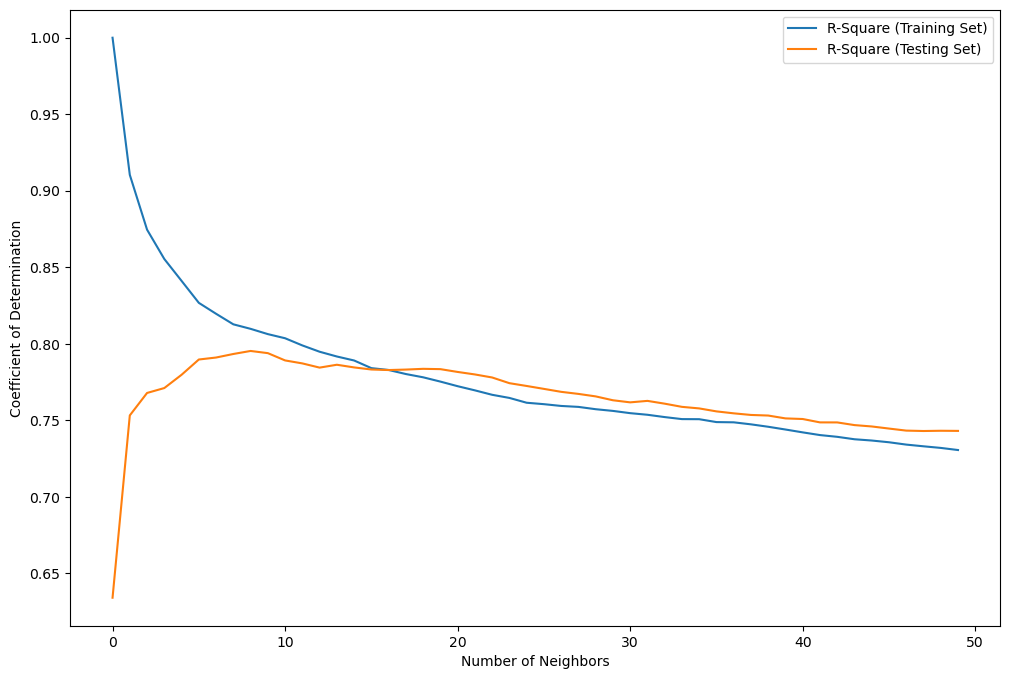


    The optimal number of neighbors is 9.
    Training R-Square: 0.8097
    Testing  R-Square: 0.7953
    Train-Test Gap:    0.0145



KNeighborsRegressor(n_neighbors=50)

In [24]:
optimize.quick_neighbors(x_data = x_data,
                         y_data = y_data)

In [25]:
from sklearn.model_selection import ParameterGrid

In [26]:
# developing hyperparameter ranges
criterion_range = ["squared_error", "friedman_mse", "absolute_error", 'poisson']
splitter_range  = ['best', 'random']    # splitter
depth_range     = np.arange(1, 20, 1)   # max_depth
leaf_range      = np.arange(.001, .101, .001)

# creating a hyperparameter grid
param_gr = {'criterion'        : criterion_range,
            'splitter'         : splitter_range,
            'max_depth'        : depth_range,
            'min_samples_leaf' : leaf_range}


# checking number of values per key
for key, value in param_gr.items():
    print(len(value))


param_grid = ParameterGrid(param_grid=param_gr)

4
2
19
100


In [ ]:
model_type = DecisionTreeRegressor(max_depth = 20,
                                   random_state = 702)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

def tree_depth_sweep(X, y, max_depth=20, random_state=702):
    """
    Trains DecisionTreeRegressor models for depths 1..max_depth (inclusive),
    and returns a DataFrame with depth, RSS, and R^2 computed on the given X,y.
    """
    rows = []
    for d in range(1, max_depth + 1):
        model = DecisionTreeRegressor(max_depth=d, random_state=random_state)
        model.fit(X, y)
        y_hat = model.predict(X)
        rss = np.sum((y - y_hat) ** 2)
        r2  = model.score(X, y)
        rows.append({"depth": d, "RSS": rss, "R2": r2})
    return pd.DataFrame(rows)

# --- Example usage ---
# Your model template:
max_model = DecisionTreeRegressor(max_depth=20, random_state=702)


# Run the sweep using its settings
results = tree_depth_sweep(X            = x_data,
                           y            = y_data,
                           max_depth    = max_model.max_depth,
                           random_state = model_type.random_state)

# View the simple table
print(results)

In [27]:
import numpy as np
import pandas as pd
from typing import Sequence
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def tree_depth_cv_sweep(
    X,
    y: Sequence[float],
    max_depth: int = 20,
    cv_folds: int = 3,
    random_state: int = 702,
) -> pd.DataFrame:
    """
    Trains DecisionTreeRegressor models for depths 1..max_depth (inclusive),
    evaluates with K-fold CV, and returns a table with depth-wise statistics.

    PARAMETERS
    ----------
    X            | array-like | feature matrix                               | No default
    y            | array-like | target vector                                | No default
    max_depth    | int        | largest tree depth to test                   | Default = 20
    cv_folds     | int        | number of folds for CV (even split intent)   | Default = 3
    random_state | int        | RNG seed for reproducibility (CV + model)    | Default = 702

    RETURNS
    -------
    A DataFrame with:
      * depth
      * folds
      * mean_RSS
      * mean_R2
      * RSS_range (max_RSS - min_RSS across folds)
      * R2_range  (max_R2  - min_R2  across folds)
    """
    y = np.asarray(y).ravel()
    rows = []

    # Even-ish splits via KFold (sizes differ by at most 1 if not divisible)
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    for d in range(1, max_depth + 1):
        rss_scores = []
        r2_scores  = []

        for train_idx, val_idx in kf.split(X):
            model = DecisionTreeRegressor(max_depth=d, random_state=random_state)
            model.fit(np.asarray(X)[train_idx], y[train_idx])

            y_val  = y[val_idx]
            y_pred = model.predict(np.asarray(X)[val_idx])

            rss = np.sum((y_val - y_pred) ** 2)      # Residual Sum of Squares on the fold
            r2  = r2_score(y_val, y_pred)            # R² on the fold

            rss_scores.append(rss)
            r2_scores.append(r2)

        rows.append({
            "depth": d,
            "folds": cv_folds,
            "mean_RSS": float(np.mean(rss_scores)),
            "mean_R2":  float(np.mean(r2_scores)),
            "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
            "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
        })

    return pd.DataFrame(rows)


# --- Example usage ---
# Model template (as provided)
model_type = DecisionTreeRegressor(max_depth=20, random_state=702)

# Run the sweep (uses validation metrics from K-fold CV)
results = tree_depth_cv_sweep(
    X            = x_data,
    y            = y_data,
    max_depth    = model_type.max_depth,
    cv_folds     = 3,                    # <— change if you want more/less folds
    random_state = model_type.random_state
)

print(results)

    depth  folds    mean_RSS   mean_R2  RSS_range  R2_range
0       1      3  694.185887  0.288107  62.914734  0.021575
1       2      3  459.822657  0.527749  68.763555  0.090473
2       3      3  373.986221  0.616754  47.676047  0.002576
3       4      3  298.075389  0.693868   5.257352  0.031564
4       5      3  268.667739  0.724111  11.359621  0.026451
5       6      3  265.535536  0.727572  24.268221  0.022336
6       7      3  273.357616  0.720226  52.077896  0.019352
7       8      3  296.605917  0.695664  57.312126  0.057107
8       9      3  316.858376  0.675552  85.499706  0.066354
9      10      3  337.782181  0.653259  63.748334  0.071424
10     11      3  319.744929  0.670695  55.330174  0.079720
11     12      3  332.060125  0.659121  59.151285  0.067273
12     13      3  340.845615  0.650405  48.512799  0.041400
13     14      3  354.950252  0.635839  63.366048  0.061069
14     15      3  358.947365  0.632165  83.909695  0.062427
15     16      3  357.690898  0.633173  

Based on below, I want to build a set of the top five winners in each category.

In [28]:
#results.sort_values(by = 'mean_RSS', ascending = True)   # 6, 5, 4, 7, 3
#results.sort_values(by = 'mean_R2' , ascending = False)  # 6, 5, 4, 7, 3
#results.sort_values(by = 'RSS_range' , ascending = True) # 4, 3, 5, 2, 6
#results.sort_values(by = 'R2_range' , ascending = True)  # 2, 3, 0, 5, 4

#set([6, 5, 4, 7, 3, 6, 5, 4, 7, 3, 4, 3, 5, 2, 6, 2, 3, 0, 5, 4])

results.loc[ [6, 5, 4, 7, 3, 2, 0] , : ].sort_values(by = 'depth')

depth_values = list(results.loc[ [6, 5, 4, 7, 3, 2, 0], 'depth'])
depth_values.sort()
depth_values

[1, 3, 4, 5, 6, 7, 8]

In [29]:
import numpy as np
import pandas as pd
from typing import Sequence, Optional
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def tree_leaf_cv_sweep(
    X,
    y: Sequence[float],
    max_leaf_samples: int = 20,
    leaf_values: Optional[Sequence[int]] = None,
    cv_folds: int = 3,
    random_state: int = 702,
) -> pd.DataFrame:
    """
    Trains DecisionTreeRegressor models across min_samples_leaf values and
    evaluates with K-fold CV. Returns a table with leaf-wise statistics.

    PARAMETERS
    ----------
    X                | array-like | feature matrix                               | No default
    y                | array-like | target vector                                | No default
    max_leaf_samples | int        | largest min_samples_leaf to test (1..N)      | Default = 20
    leaf_values      | sequence   | explicit list of min_samples_leaf values     | Default = None
    cv_folds         | int        | number of folds for CV                       | Default = 3
    random_state     | int        | RNG seed for reproducibility                  | Default = 702

    RETURNS
    -------
    A DataFrame with:
      * min_samples_leaf
      * folds
      * mean_RSS
      * mean_R2
      * RSS_range (max_RSS - min_RSS across folds)
      * R2_range  (max_R2  - min_R2  across folds)
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    # Build the grid of min_samples_leaf values to test
    if leaf_values is None:
        leaf_values = range(1, max_leaf_samples + 1)

    rows = []
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    for leaf in leaf_values:
        rss_scores = []
        r2_scores  = []

        #!# specifies the model directly instead of having it as a parameter. Change this.
        for train_idx, val_idx in kf.split(X):
            model = DecisionTreeRegressor(
                min_samples_leaf=leaf,
                random_state=random_state
            )
            model.fit(X[train_idx], y[train_idx])

            y_val  = y[val_idx]
            y_pred = model.predict(X[val_idx])

            rss = np.sum((y_val - y_pred) ** 2)
            r2  = r2_score(y_val, y_pred)

            rss_scores.append(rss)
            r2_scores.append(r2)

        rows.append({
            "min_samples_leaf": int(leaf),
            "folds": cv_folds,
            "mean_RSS": float(np.mean(rss_scores)),
            "mean_R2":  float(np.mean(r2_scores)),
            "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
            "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
        })

    return pd.DataFrame(rows)

In [30]:
# --- Example usage ---
# Matches your original template style, but now sweeping min_samples_leaf
model_type = DecisionTreeRegressor(random_state=702) #!# add in max_leaf_samples as a parameter

results_leaf = tree_leaf_cv_sweep(
    X = x_data,
    y = y_data,
    max_leaf_samples= 200,                 # or pass leaf_values=[1,2,5,10,20] etc.
    cv_folds=3,
    random_state=model_type.random_state
)

#print(results_leaf.sort_values(by = 'mean_RSS'))

In [31]:
print(results_leaf.sort_values(by = 'mean_R2', ascending = False))

     min_samples_leaf  folds    mean_RSS   mean_R2   RSS_range  R2_range
12                 13      3  247.844303  0.745187    8.783475  0.039630
18                 19      3  248.659639  0.744556    6.683199  0.029495
16                 17      3  249.129709  0.743930   15.383089  0.036632
15                 16      3  249.252269  0.743877   11.154003  0.033029
19                 20      3  249.839616  0.743345    7.108816  0.029537
11                 12      3  250.013151  0.743193    7.653478  0.028293
17                 18      3  250.867397  0.742265    4.913497  0.030898
20                 21      3  251.031534  0.741991    7.800641  0.036152
21                 22      3  251.295722  0.741644    8.541786  0.039927
14                 15      3  252.925904  0.739854   14.182334  0.045866
9                  10      3  253.848123  0.738956   18.625156  0.043561
13                 14      3  254.106011  0.738809   17.529880  0.037663
10                 11      3  254.823642  0.737993 

In [32]:
#results_leaf.sort_values(by = 'mean_RSS', ascending = True)    # 11, 18, 19, 12, 16
#results_leaf.sort_values(by = 'mean_R2' , ascending = False)   # 11, 18, 19, 12, 16 
#results_leaf.sort_values(by = 'RSS_range' , ascending = True)  # 14, 11, 7, 13, 32
#results_leaf.sort_values(by = 'R2_range' , ascending = True)   # 19, 18, 28, 15, 29

#set([11, 18, 19, 12, 16, 11, 18, 19, 12, 16, 14, 11, 7, 13, 32, 19, 18, 28, 15, 29])

results_leaf.loc[ [7, 11, 12, 13, 14, 15, 16, 18, 19, 28, 29, 32] , : ].sort_values(by = 'min_samples_leaf')

leaf_values = list(results_leaf.loc[ [7, 11, 12, 13, 14, 15, 16, 18, 19, 28, 29, 32], 'min_samples_leaf'])
leaf_values.sort()
leaf_values

[8, 12, 13, 14, 15, 16, 17, 19, 20, 29, 30, 33]

In [33]:
def tree_depth_leaf_cv_sweep(
    X,
    y: Sequence[float],
    max_depth: int = 20,
    max_leaf_samples: int = 20,
    depths: Optional[Sequence[int]] = None,
    leaf_values: Optional[Sequence[int]] = None,
    cv_folds: int = 3,
    random_state: int = 702,
) -> pd.DataFrame:
    """
    Trains DecisionTreeRegressor models across combinations of max_depth and
    min_samples_leaf, evaluates with K-fold CV, and returns a results table.

    PARAMETERS
    ----------
    X                | array-like | feature matrix                              | No default
    y                | array-like | target vector                               | No default
    max_depth        | int        | largest depth tested if depths not provided | Default = 20
    max_leaf_samples | int        | largest min_samples_leaf if none provided   | Default = 20
    depths           | sequence   | explicit list of depths to test             | Default = None
    leaf_values      | sequence   | explicit list of min_samples_leaf values    | Default = None
    cv_folds         | int        | number of folds for CV                      | Default = 3
    random_state     | int        | RNG seed for reproducibility                | Default = 702

    RETURNS
    -------
    A DataFrame with columns:
      * depth
      * min_samples_leaf
      * folds
      * mean_RSS
      * mean_R2
      * RSS_range  (max_RSS - min_RSS across folds)
      * R2_range   (max_R2  - min_R2  across folds)
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    # Build grids if not provided
    if depths is None:
        depths = range(1, max_depth + 1)
    if leaf_values is None:
        leaf_values = range(1, max_leaf_samples + 1)

    rows = []
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    for d in depths:
        for leaf in leaf_values:
            rss_scores = []
            r2_scores  = []

            for train_idx, val_idx in kf.split(X):
                model = DecisionTreeRegressor(
                    max_depth=d,
                    min_samples_leaf=leaf,
                    random_state=random_state
                )
                model.fit(X[train_idx], y[train_idx])

                y_val  = y[val_idx]
                y_pred = model.predict(X[val_idx])

                rss = float(np.sum((y_val - y_pred) ** 2))
                r2  = float(r2_score(y_val, y_pred))

                rss_scores.append(rss)
                r2_scores.append(r2)

            rows.append({
                "depth": int(d),
                "min_samples_leaf": int(leaf),
                "folds": cv_folds,
                "mean_RSS": float(np.mean(rss_scores)),
                "mean_R2":  float(np.mean(r2_scores)),
                "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
                "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
            })

    results = pd.DataFrame(rows)
    # Optional: sort for tidy display
    #results = results.sort_values(["depth", "min_samples_leaf"]).reset_index(drop=True)
    return results




In [34]:
# max grid (40-45 seconds)
results_grid = tree_depth_leaf_cv_sweep(
    X = x_data,
    y = y_data,
    max_depth = 20,
    max_leaf_samples = 200,
    cv_folds=3,
    random_state=702
)

KeyboardInterrupt: 

In [ ]:
#results_grid.sort_values(by = 'mean_RSS', ascending = True).head(n = 15)
# depth: 9, 16, 17, 20, 19, 15, 14, 18
# leaf : 12 ties eight times #!# need to consider ties
# indexes: 1611, 3011, 3211, 3811, 3611, 2811, 2611, 3411

#results_grid.sort_values(by = 'mean_R2' , ascending = False).head(n = 15)
# depth: 9, 14, 19, 18, 15, 20, 16, 17
# leaf : 12 ties eight times
# indexes: 1611, 2611, 3611, 3411, 2811, 3811, 3011, 3211

#results_grid.sort_values(by = 'RSS_range' , ascending = True).head(n = 15)
# depth: 6, 5, 5, 6, 5
# leaf : 11, 9, 10, 10, 11
# indexes: 1010, 808, 809, 1009, 810

#results_grid.sort_values(by = 'R2_range' , ascending = True).head(n = 15)
# depth: 8, 3, 3, 8, 7, 7
# leaf : 20, 1, 2, 19, 20, 19
# indexes: 1419, 400, 401, 1418, 1219

# # set of indexes
# set([1611, 3011, 3211, 3811, 3611, 2811, 2611, 3411,
#      1611, 2611, 3611, 3411, 2811, 3811, 3011, 3211,
#      1010, 808, 809, 1009, 810,
#      1419, 400, 401, 1418, 1219])

# multi-parameter results (18 models)
results_grid.loc[ [400, 401, 808, 809, 810, 1009, 1010, 1219, 1418, 1419,
                   1611, 2611, 2811, 3011, 3211, 3411, 3611, 3811] , : ].sort_values(by = 'mean_RSS')

In [ ]:
# putting the three sets together
depth_res = results.loc[ [6, 5, 4, 7, 3, 2, 0] , : ].sort_values(by = 'depth')
leaf_res  = results_leaf.loc[ [7, 11, 12, 13, 14, 15, 16, 18, 19, 28, 29, 32] , : ].sort_values(by = 'min_samples_leaf')
multi_res = results_grid.loc[ [400, 401, 808, 809, 810, 1009, 1010, 1219, 1418, 1419,
                               1611, 2611, 2811, 3011, 3211, 3411, 3611, 3811] , : ].sort_values(by = 'mean_RSS')


# adding set identifier
depth_res['set'] = 'depth'
leaf_res['set']  = 'leaf'
multi_res['set'] = 'multi'

In [ ]:
all_results = pd.concat(objs = [multi_res, depth_res, leaf_res],
                        axis = 0)


# 28 unique rows
len(all_results.drop_duplicates(subset = ['mean_RSS', 'mean_R2', 'RSS_range', 'R2_range'],
                            keep = 'first'))

In [ ]:
# performance ties for the three approaches
all_results[all_results[['mean_RSS', 'mean_R2', 'RSS_range', 'R2_range']].duplicated()]

In [ ]:
depth_values
leaf_values

In [ ]:
# multi not in depth:    9, 14, 15, 16, 17, 18, 19, 20
# multi but not in leaf: 11, 10, 9, 2, 1

### ranges! # nope, doesn't work :(
# depth = range(1, 8+1)
# leaf  = range(8, 33+1)

In [ ]:
all_results[all_results['set'] == 'multi'].sort_values(by = 'mean_R2', ascending=False)

In [ ]:
#results.sort_values(by = 'mean_R2', ascending = False)
#results_leaf.sort_values(by = 'mean_R2', ascending = False)
results_grid.sort_values(by = 'mean_R2', ascending = False).head(n = 15)

## Testing Part III

In [ ]:
import numpy as np
import pandas as pd
from typing import Sequence, Optional, Iterable, Set
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def _cv_metrics_for_leaf(
    X: np.ndarray,
    y: np.ndarray,
    leaf: int,
    cv_folds: int,
    random_state: int
) -> dict:
    """
    Helper: compute CV metrics for a given min_samples_leaf value.
    Returns a dict with mean_RSS, mean_R2, RSS_range, R2_range.
    """
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    rss_scores, r2_scores = [], []

    for train_idx, val_idx in kf.split(X):
        model = DecisionTreeRegressor(
            min_samples_leaf=leaf,
            random_state=random_state
        )
        model.fit(X[train_idx], y[train_idx])
        y_val  = y[val_idx]
        y_pred = model.predict(X[val_idx])

        rss_scores.append(float(np.sum((y_val - y_pred) ** 2)))
        r2_scores.append(float(r2_score(y_val, y_pred)))

    return {
        "min_samples_leaf": int(leaf),
        "mean_RSS":  float(np.mean(rss_scores)),
        "mean_R2":   float(np.mean(r2_scores)),
        "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
        "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
    }

def _select_top_n_unique(
    df: pd.DataFrame,
    metric: str,
    n: int,
    direction: str
) -> Iterable[int]:
    """
    Helper: select the top-n unique min_samples_leaf values by a metric.
    direction: 'lower' or 'higher'. Does NOT include ties beyond n.
    Stable secondary sort by min_samples_leaf ascending for determinism.
    """
    ascending = (direction == "lower")
    ranked = df.sort_values([metric, "min_samples_leaf"], ascending=[ascending, True])
    picked: Set[int] = set()
    for _, row in ranked.iterrows():
        leaf = int(row["min_samples_leaf"])
        if leaf not in picked:
            picked.add(leaf)
            if len(picked) == n:
                break
    return picked

def tree_depth_leaf_two_stage_cv(
    X,
    y: Sequence[float],
    *,
    # Stage 1 (leaf tuning search space)
    max_leaf_samples: int = 20,
    leaf_values: Optional[Sequence[int]] = None,
    # Stage 2 (depth grid)
    max_depth: int = 20,
    depths: Optional[Sequence[int]] = None,
    # CV and selection
    cv_folds: int = 3,
    n: int = 5,                 # top-n per metric (no ties beyond n)
    random_state: int = 702,
) -> pd.DataFrame:
    """
    Two-stage CV procedure:

    1) Tune min_samples_leaf alone:
       - Evaluate a CV sweep over candidate min_samples_leaf values.
       - For each metric, select the top-n UNIQUE min_samples_leaf values
         (no ties beyond n):
           * mean_RSS   (lower is better)
           * mean_R2    (higher is better)
           * RSS_range  (lower is better)
           * R2_range   (lower is better)

    2) Build a hyperparameter grid:
       - Depth grid = all given depths (1..max_depth if not provided)
       - Leaf grid  = UNION of the four top-n sets from step (1)
         (unique deduped, sorted ascending).

    3) Evaluate all (depth, min_samples_leaf) combinations via CV and
       return a DataFrame with:
         * depth
         * min_samples_leaf
         * folds
         * mean_RSS
         * mean_R2
         * RSS_range  (max_RSS - min_RSS across folds)
         * R2_range   (max_R2  - min_R2  across folds)
    """
    # --- Normalize inputs ---
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    if leaf_values is None:
        leaf_values = range(1, max_leaf_samples + 1)
    if depths is None:
        depths = range(1, max_depth + 1)

    # =========================
    # Stage 1: tune min_samples_leaf
    # =========================
    leaf_rows = []
    for leaf in leaf_values:
        metrics = _cv_metrics_for_leaf(X, y, leaf=leaf, cv_folds=cv_folds, random_state=random_state)
        leaf_rows.append(metrics)
    leaf_df = pd.DataFrame(leaf_rows)

    # Select top-n unique leafs per metric
    top_by_mean_rss = _select_top_n_unique(leaf_df, "mean_RSS",  n, direction="lower")
    top_by_mean_r2  = _select_top_n_unique(leaf_df, "mean_R2",   n, direction="higher")
    top_by_rss_rng  = _select_top_n_unique(leaf_df, "RSS_range", n, direction="lower")
    top_by_r2_rng   = _select_top_n_unique(leaf_df, "R2_range",  n, direction="lower")

    # Union of all selected leaf values
    tuned_leaf_grid = sorted(set().union(top_by_mean_rss, top_by_mean_r2, top_by_rss_rng, top_by_r2_rng))

    # =========================
    # Stage 2: evaluate depth × tuned_leaf_grid
    # =========================
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    rows = []

    for d in depths:
        for leaf in tuned_leaf_grid:
            rss_scores, r2_scores = [], []
            for train_idx, val_idx in kf.split(X):
                model = DecisionTreeRegressor(
                    max_depth=d,
                    min_samples_leaf=leaf,
                    random_state=random_state
                )
                model.fit(X[train_idx], y[train_idx])

                y_val  = y[val_idx]
                y_pred = model.predict(X[val_idx])

                rss_scores.append(float(np.sum((y_val - y_pred) ** 2)))
                r2_scores.append(float(r2_score(y_val, y_pred)))

            rows.append({
                "depth": int(d),
                "min_samples_leaf": int(leaf),
                "folds": cv_folds,
                "mean_RSS": float(np.mean(rss_scores)),
                "mean_R2":  float(np.mean(r2_scores)),
                "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
                "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
            })

    # =========================
    # Stage 3: return results
    # =========================
    results = pd.DataFrame(rows).sort_values(
        ["depth", "min_samples_leaf"], ascending=[True, True]
    ).reset_index(drop=True)

    return results

In [ ]:
# takes ~6 seconds to run
results_df = tree_depth_leaf_two_stage_cv(
    X = x_data,
    y = y_data,
    max_leaf_samples=20,                       # leaf search space for Stage 1
    #leaf_values=None,                          # or pass an explicit list
    max_depth=20,                              # depth grid upper bound
    #depths=[2, 4, 6, 8, 10, 12],               # or pass explicit depths
    cv_folds=3,
    n=5,
    random_state=702
)

In [ ]:
results_df.sort_values(by = 'mean_RSS',
                       ascending = True)

In [ ]:
from typing import Any, Dict, List, Mapping, Optional, Sequence, Tuple, Union

def tuning_results(
    cv_results: Union[Mapping[str, Any], Any],
    n: int = 1,
    round_digits: int = 6,
) -> pd.DataFrame:
    """
    Extracts the top-n hyperparameter tuning results from sklearn model
    selection tools (GridSearchCV or RandomizedSearchCV). Outputs an organized
    DataFrame containing:
        * Model Rank       (rank_test_score)
        * Mean Test Score  (mean_test_score)
        * StDev Test Score (std_test_score)
        * Best Parameters  (best_params)

    PARAMETERS
    ----------
    cv_results : dict or fitted search object
        Either the dictionary from `.cv_results_` or a fitted GridSearchCV /
        RandomizedSearchCV object (the function will read `.cv_results_` if
        present).
    n : int, default=1
        The number of top ranks to include. All rows with rank_test_score <= n
        are returned (i.e., ties are included).

    RETURNS
    -------
    pd.DataFrame
    """
    # allow passing the fitted search object directly
    if hasattr(cv_results, "cv_results_"):
        cv_results = cv_results.cv_results_

    # validation - ensuring dict-like object
    if not isinstance(cv_results, Mapping):
        raise TypeError("cv_results must be a dict-like object or a fitted search with .cv_results_")
    
    # validation - checking keys
    required = {"params", "rank_test_score", "mean_test_score"}
    missing = required.difference(cv_results.keys())
    if missing:
        raise KeyError(f"cv_results is missing required keys: {sorted(missing)}")
        
    
    try:
        # instantiating results DataFrame
        df = pd.DataFrame(data = cv_results)[['rank_test_score',
                                              'mean_test_score',
                                              'std_test_score' ,
                                              'params']]

    except:
        # instantiating partial results DataFrame
        df = pd.DataFrame(data = cv_results)[['rank_test_score',
                                              'mean_test_score',
                                              'params']]
        
        # avoiding issue with older/custom scorers
        if "std_test_score" not in df.columns:
            df["std_test_score"] = pd.NA
        
        
        
    # renaming columns
    df = df.rename(columns={"rank_test_score": "Model Rank",
                            "mean_test_score": "Mean Test Score",
                            "std_test_score" : "SD Test Score",
                            "params": "Parameters"})
    
    
    # clamping n and filtering by rank (include ties)
    n = max(int(n), 1)
    top = df.loc[df["Model Rank"] <= n].copy()

    # sorting (highest rank followed by lowest standard deviation
    top = top.sort_values(["Model Rank", "SD Test Score"],
                          ascending=[True, False]).reset_index(drop=True)
    

    return top

In [ ]:
import numpy as np
import pandas as pd
from typing import Sequence, Optional, Iterable, Set, Mapping, Any, Union
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# --- assumes your tuning_results(cv_results, n, round_digits) is already defined in scope ---

def _top_leafs_via_mean(
    X: np.ndarray,
    y: np.ndarray,
    leaf_values: Sequence[int],
    cv: KFold,
    scorer_name: str,
    scorer,
    n: int,
    random_state: int,
) -> Set[int]:
    """
    Run GridSearchCV over min_samples_leaf with a single scorer,
    pass to tuning_results, and pull the top-n unique leaf values.
    """
    grid = {"min_samples_leaf": list(leaf_values)}
    est  = DecisionTreeRegressor(random_state=random_state)
    gs   = GridSearchCV(est, grid, scoring=scorer, cv=cv, refit=True, n_jobs=None)
    gs.fit(X, y)

    # Use the user's helper to extract top ranks (ties included)
    top_df = tuning_results(gs, n=n)

    # Extract unique leaf values from the returned Parameters column
    return {int(p["min_samples_leaf"]) for p in top_df["Parameters"]}


def _top_leafs_via_range(
    X: np.ndarray,
    y: np.ndarray,
    leaf_values: Sequence[int],
    cv: KFold,
    scorer_name: str,
    scorer,
    n: int,
    random_state: int,
    *,
    convert_to_rss: bool = False,
    split_sizes: Optional[Sequence[int]] = None,
) -> Set[int]:
    """
    Run GridSearchCV to capture split-wise scores, compute per-param RANGE across folds,
    and return the top-n unique leafs with the *lowest* range.

    If convert_to_rss=True, we interpret the scorer as neg_mean_squared_error and
    transform split scores from MSE to RSS by multiplying by the split test size.
    """
    grid = {"min_samples_leaf": list(leaf_values)}
    est  = DecisionTreeRegressor(random_state=random_state)
    gs   = GridSearchCV(est, grid, scoring=scorer, cv=cv, refit=True, n_jobs=None)
    gs.fit(X, y)

    cvres = gs.cv_results_
    # Collect split columns present in cv_results_ for this scorer
    # Columns are like 'split0_test_score' regardless of scorer name when a single scorer is used
    split_cols = [c for c in cvres.keys() if c.startswith("split") and c.endswith("_test_score")]
    split_cols = sorted(split_cols, key=lambda c: int(c.split("split")[1].split("_")[0]))

    # Build a DataFrame with params and all split scores
    df = pd.DataFrame({
        "min_samples_leaf": [p["min_samples_leaf"] for p in cvres["params"]],
        **{c: cvres[c] for c in split_cols}
    })

    # Optionally convert from scores to RSS if the scorer is neg_mean_squared_error
    if convert_to_rss:
        if split_sizes is None or len(split_sizes) != len(split_cols):
            raise ValueError("split_sizes must be provided and match the number of CV splits when convert_to_rss=True.")
        for i, c in enumerate(split_cols):
            # score = NEGATIVE MSE  ->  MSE = -score  ->  RSS = MSE * n_split
            df[c] = (-df[c]) * int(split_sizes[i])

    # Compute the range across splits
    split_vals = df[split_cols].to_numpy()
    ranges = split_vals.max(axis=1) - split_vals.min(axis=1)
    df["metric_range"] = ranges

    # Pick top-n *lowest* ranges (no ties beyond n), stable by leaf ascending
    df = df.sort_values(["metric_range", "min_samples_leaf"], ascending=[True, True])
    picked: Set[int] = set()
    out: Set[int] = set()
    for _, row in df.iterrows():
        leaf = int(row["min_samples_leaf"])
        if leaf not in picked:
            picked.add(leaf)
            out.add(leaf)
            if len(out) == n:
                break
    return out


def tree_depth_leaf_two_stage_cv_tuned(
    X,
    y: Sequence[float],
    *,
    # Stage 1 search space for leafs
    max_leaf_samples: int = 20,
    leaf_values: Optional[Sequence[int]] = None,
    # Stage 2 depth grid
    max_depth: int = 20,
    depths: Optional[Sequence[int]] = None,
    # CV + selection config
    cv_folds: int = 3,
    n: int = 5,                     # top-n per metric (include ties via tuning_results; capped to n unique in union)
    random_state: int = 702,
) -> pd.DataFrame:
    """
    Two-stage CV that *utilizes tuning_results* for mean-metric selection:

    Stage 1 — Tune min_samples_leaf alone:
      • Run GridSearchCV twice over min_samples_leaf:
          - Scorer 1: neg_mean_squared_error (proxy for RSS; lower MSE -> lower RSS)
          - Scorer 2: r2
        Feed each search to `tuning_results(...)` to get the top-n (with ties) rows,
        and collect their UNIQUE min_samples_leaf values.
      • Also compute per-param RANGE across folds for:
          - RSS_range (derived from neg_mean_squared_error × fold sizes)
          - R2_range  (range of per-fold r2 scores)
        Select the top-n UNIQUE leafs with the smallest ranges (no ties beyond n).

      Final leaf grid = UNION of the four sets above.

    Stage 2 — Evaluate full grid:
      • Depth grid: all given depths (1..max_depth if not provided)
      • Leaf grid : tuned set from Stage 1
      • For every (depth, leaf) pair, compute CV metrics and return a DataFrame with:
          depth, min_samples_leaf, folds, mean_RSS, mean_R2, RSS_range, R2_range
    """
    # Normalize inputs
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    if leaf_values is None:
        leaf_values = list(range(1, max_leaf_samples + 1))
    else:
        leaf_values = list(leaf_values)

    if depths is None:
        depths = list(range(1, max_depth + 1))
    else:
        depths = list(depths)

    # Construct a deterministic CV splitter we can reuse everywhere
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    # Precompute test split sizes so we can turn MSE into RSS later
    split_sizes = [len(test_idx) for _, test_idx in kf.split(X)]

    # ---- Stage 1A: mean metrics via tuning_results (GridSearchCV) ----
    # mean_RSS (lower is better)  -> use neg_mean_squared_error
    neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    top_by_mean_rss = _top_leafs_via_mean(
        X, y, leaf_values, kf, "neg_mean_squared_error", neg_mse_scorer, n, random_state
    )

    # mean_R2  (higher is better) -> use r2
    r2_scorer = make_scorer(r2_score, greater_is_better=True)
    top_by_mean_r2 = _top_leafs_via_mean(
        X, y, leaf_values, kf, "r2", r2_scorer, n, random_state
    )

    # ---- Stage 1B: range metrics from split-wise scores (GridSearchCV) ----
    # RSS_range (lower is better) using neg MSE -> convert to RSS using split sizes
    top_by_rss_range = _top_leafs_via_range(
        X, y, leaf_values, kf, "neg_mean_squared_error", neg_mse_scorer, n, random_state,
        convert_to_rss=True, split_sizes=split_sizes
    )

    # R2_range (lower is better) directly from split r2 scores
    top_by_r2_range = _top_leafs_via_range(
        X, y, leaf_values, kf, "r2", r2_scorer, n, random_state,
        convert_to_rss=False, split_sizes=None
    )

    # Union of leafs from the four criteria
    tuned_leaf_grid = sorted(set().union(
        top_by_mean_rss, top_by_mean_r2, top_by_rss_range, top_by_r2_range
    ))

    # ---- Stage 2: evaluate depth × tuned_leaf_grid and compute full metrics ----
    rows = []
    for d in depths:
        for leaf in tuned_leaf_grid:
            rss_scores, r2_scores = [], []
            for train_idx, val_idx in kf.split(X):
                model = DecisionTreeRegressor(
                    max_depth=d,
                    min_samples_leaf=leaf,
                    random_state=random_state
                )
                model.fit(X[train_idx], y[train_idx])

                y_val  = y[val_idx]
                y_pred = model.predict(X[val_idx])

                # Per-fold metrics
                rss_scores.append(float(np.sum((y_val - y_pred) ** 2)))
                r2_scores.append(float(r2_score(y_val, y_pred)))

            rows.append({
                "depth": int(d),
                "min_samples_leaf": int(leaf),
                "folds": cv_folds,
                "mean_RSS": float(np.mean(rss_scores)),
                "mean_R2":  float(np.mean(r2_scores)),
                "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
                "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
            })

    results = pd.DataFrame(rows).sort_values(
        ["depth", "min_samples_leaf"], ascending=[True, True]
    ).reset_index(drop=True)

    return results

In [ ]:
# ~21 seconds
results_df = tree_depth_leaf_two_stage_cv_tuned(
    X = x_data,
    y = y_data,
    max_leaf_samples=200,                 # Stage-1 leaf search space
    #leaf_values=None,                    # or an explicit list like [1,2,3,4,5,8,13,21]
    max_depth=20,                        # Stage-2 depth search space
    #depths=[2,4,6,8,10,12],              # or leave None to use 1..max_depth
    cv_folds=3,
    n=5,
    random_state=702
)

In [ ]:
results_df.sort_values(by = 'mean_RSS',
                       ascending = True)

In [ ]:
# set grid
depths_list = [2, 4, 6, 8]
leaf_list   = [1, 2, 5, 10]
results_grid = tree_depth_leaf_cv_sweep(
    X, y,
    depths=depths_list,
    leaf_values=leaf_list,
    cv_folds=3,
    random_state=702
)
print(results_grid)

In [ ]:
# standardizing each set
#print(results_leaf.sort_values(by = 'mean_R2', ascending = False))
#print(results.sort_values(by = 'mean_R2', ascending = False))
print(all_results.sort_values(by = 'mean_R2', ascending=False))

### Checking combinations of the above v. brute force tuning.
Step after this one: Do this as a range for whatever hps are in the top results.

Each test resulted in the same indexes for RSS and R2, although in a multidimensional grid, the indexes did not follow the same order for these metrics.

In [ ]:
# imports
from sklearn.model_selection import GridSearchCV

## standard tuning grid ##
depth_range = [1, 3, 4, 5, 6, 7, 8]
leaf_range  = [8, 12, 13, 14, 15, 16, 17, 19, 20, 29, 30, 33]

param_gr = {'max_depth'        : depth_range,
            'min_samples_leaf' : leaf_range}


# INSTANTIATING the model object without hyperparameters
model_type = DecisionTreeRegressor(random_state = 702)

# placeholder df to store results
combo_results = pd.DataFrame(data = None)

# developing parameter grid
param_grid = ParameterGrid(param_gr)

## hp tuning ##
for p in param_grid:
    
    # testing hyperparameter combinations
    model = DecisionTreeRegressor(**p               ,
                                  random_state = 702)

    # storing results
    results_2 = sklearn_tree_summary(x          = x_data,
                                     y          = y_data,
                                     model      = model,
                                     model_name = f"{dataset.split(sep = '.')[0]}_x-full_y-base",
                                     results_df = results_2,
                                     f_names    = full_feature_names)

# checking results
results_2.head(n = 5)

In [ ]:
from __future__ import annotations
from typing import Any, Dict, List, Mapping, Optional, Sequence, Tuple, Union, Iterable, Set
import numpy  as np                            # numerical essentials
import pandas as pd                            # data science essentials
import statsmodels.api as sm                   # p-values
from sklearn.model_selection import KFold      # cross validation
from sklearn.metrics import r2_score           # r-squared
from sklearn.tree import DecisionTreeRegressor # decision tree regressor

def _cv_metrics_for_leaf(
    x_data: np.ndarray,
    y_data: np.ndarray,
    model_type: Optional[Callable[..., object]] = None,
    leaf: int = 200,
    cv_folds: int = 3,
    random_state: int = 702,
) -> dict:
    """
    Helper: compute CV metrics for a given min_samples_leaf value (Stage 1).
    Uses a lightweight DecisionTreeRegressor model.

    RETURNS a dict with: mean_RSS, mean_R2, RSS_range, R2_range
    """

    # Default model type == DecisionTreeRegressor
    if model_type is None:
        from sklearn.tree import DecisionTreeRegressor
        model_type = DecisionTreeRegressor

    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data).ravel()

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    rss_scores = []
    r2_scores  = []

    for train_idx, val_idx in kf.split(x_data):
        model = model_type(min_samples_leaf = leaf,
                           random_state     = random_state)
        
        model.fit(x_data[train_idx], y_data[train_idx])

        y_val  = y_data[val_idx]
        y_pred = model.predict(x_data[val_idx])

        rss_scores.append(float(np.sum((y_val - y_pred) ** 2)))
        r2_scores.append(float(r2_score(y_val, y_pred)))

    return {
        "min_samples_leaf": int(leaf),
        "mean_RSS":  float(np.mean(rss_scores)),
        "mean_R2":   float(np.mean(r2_scores)),
        "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
        "R2_range":  float(np.max(r2_scores)  - np.min(r2_scores)),
    }


def _select_top_n_unique(
    df: pd.DataFrame,
    metric: str,
    n: int,
    asc: bool = True
) -> Iterable[int]:
    """
    Helper: select the top-n unique min_samples_leaf values by a metric.
    direction: 'lower' or 'higher'. Does NOT include ties beyond n.
    Stable secondary sort by min_samples_leaf ascending for determinism.
    """
    
    # sorting results
    ranked = df.sort_values([metric, "min_samples_leaf"],
                             ascending = asc,
                             kind      = "mergesort")
    


    # Keep first occurrence per leaf in the ranked order, then take the top n
#     top = (
#         ranked
#         .drop_duplicates(subset=["min_samples_leaf"], keep="first")
#         .head(n)["min_samples_leaf"]
#         .astype(int)
#         .tolist()
#     )
    
    return ranked.head(n=n)


# ===============================================================
# quick_tree (two-stage CV with lightweight estimator)
# ===============================================================
def quick_tree(
    x_data,
    y_data: Sequence[float],
    model_type: Callable[..., object] = None,
    max_leaf_samples: int = 50,
    leaf_values: Optional[Sequence[int]] = None,
    max_depth: int = 20,
    depths: Optional[Sequence[int]] = None,
    cv_folds: int = 3,
    n: int = 5,
    random_state: int = 702,
) -> pd.DataFrame:
    """
    Quickly tunes a tree-based model using a two-stage cross-validated
    procedure.

    PARAMETERS
    ----------
    x_data            | array-like | feature matrix                               | No default
    y_data            | array-like | target vector                                | No default
    model_type        | model      | tree-based model type                        | Default = DTree (Reg)
    max_leaf_samples  | int        | largest min_samples_leaf if leaf_values None | Default = 50
    leaf_values       | seq[int]   | explicit set of min_samples_leaf candidates  | Default = None
    max_depth         | int        | largest depth tested if depths None          | Default = 20
    depths            | seq[int]   | explicit set of depths to evaluate           | Default = None
    cv_folds          | int        | number of CV folds                           | Default = 3
    n                 | int        | top-n unique per metric (no ties beyond n)   | Default = 5
    random_state      | int        | RNG seed for KFold and models                | Default = 702

    RETURNS
    -------
    DataFrame with:
      * depth
      * min_samples_leaf
      * folds
      * mean_RSS
      * mean_R2
      * RSS_range (max_RSS - min_RSS across folds)
      * R2_range  (max_R2  - min_R2  across folds)
    """

    # Default model type == DecisionTreeRegressor
    if model_type is None:
        from sklearn.tree import DecisionTreeRegressor
        model_type = DecisionTreeRegressor

    # --- Normalize inputs ---
    X = np.asarray(x_data)
    y = np.asarray(y_data).ravel()

    if leaf_values is None:
        leaf_values = range(1, max_leaf_samples + 1)
    if depths is None:
        depths = range(1, max_depth + 1)

    # =========================
    # Stage 1: tune min_samples_leaf (ALWAYS lightweight estimator)
    # =========================
    leaf_rows = []
    for leaf in leaf_values:
        metrics = _cv_metrics_for_leaf(
            X, y,
            model_type=model_type,
            leaf=leaf,
            cv_folds=cv_folds,
            random_state=random_state
        )
        leaf_rows.append(metrics)
    leaf_df = pd.DataFrame(leaf_rows)

    # Select top-n unique leafs per metric
    top_by_mean_rss = _select_top_n_unique(leaf_df, "mean_RSS",  n, asc=True)
    top_by_mean_r2  = _select_top_n_unique(leaf_df, "mean_R2",   n, asc=False)
    top_by_rss_rng  = _select_top_n_unique(leaf_df, "RSS_range", n, asc=True)
    top_by_r2_rng   = _select_top_n_unique(leaf_df, "R2_range",  n, asc=True)

    
    # concatenating results and dropping duplicates
    tuned_leaves = pd.concat(objs = [top_by_mean_rss,
                                     top_by_mean_r2,
                                     top_by_rss_rng,
                                     top_by_r2_rng],
                             axis = 0).drop_duplicates()
    
    
    # preparing leaf values
    tuned_leaf_grid = tuned_leaves['min_samples_leaf']


    # =========================
    # Stage 2: evaluate depth × tuned_leaf_grid with final model_type
    # =========================
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    rows = []

    for d in depths:
        for leaf in tuned_leaf_grid:
            rss_scores, r2_scores = [], []
            for train_idx, val_idx in kf.split(X):
                model = model_type(
                    max_depth=d,
                    min_samples_leaf=leaf,
                    random_state=random_state
                )
                model.fit(X[train_idx], y[train_idx])

                y_val  = y[val_idx]
                y_pred = model.predict(X[val_idx])

                rss_scores.append(float(np.sum((y_val - y_pred) ** 2)))
                r2_scores.append(float(r2_score(y_val, y_pred)))

            rows.append({
                "depth": int(d),
                "min_samples_leaf": int(leaf),
                "folds": cv_folds,
                "mean_RSS" : float(np.mean(rss_scores)),
                "mean_R2"  :  float(np.mean(r2_scores)),
                "RSS_range": float(np.max(rss_scores) - np.min(rss_scores)),
                "R2_range" :  float(np.max(r2_scores)  - np.min(r2_scores)),
            })

    
    # preparing DataFrame
    depth_df = pd.DataFrame(rows)
    
    # selecting the top models per metric
    top_by_mean_rss = _select_top_n_unique(depth_df, "mean_RSS",  n, asc=True)
    top_by_mean_r2  = _select_top_n_unique(depth_df, "mean_R2",   n, asc=False)
    top_by_rss_rng  = _select_top_n_unique(depth_df, "RSS_range", n, asc=True)
    top_by_r2_rng   = _select_top_n_unique(depth_df, "R2_range",  n, asc=True)
    
    # concatenating results and dropping duplicates
    tuned_depth = pd.concat(objs = [top_by_mean_rss,
                                    top_by_mean_r2 ,
                                    top_by_rss_rng ,
                                    top_by_r2_rng] ,
                            axis = 0).drop_duplicates()\
                                     .sort_values(by='mean_RSS')\
                                     .reset_index()
    
    return tuned_depth

In [ ]:
# line 175

quick_tree(x_data           = x_data,
           y_data           = y_data,
           max_leaf_samples = 50,
           max_depth        = 10,
           n                = 5)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

## quick neighbors ##
def quick_neighbors(x_data,
                    y_data,
                    standardize = True, # use simple_scaler
                    metric      = 'minkowski',
                    algorithm   = 'auto',
                    weights     = 'uniform'
                    njobs       = -1):
    """
    Stages:
    1. Standardizes the data.
    2. Find the top n number of neighbors on training and testing sets.
    3. Test the top neighbors on p... see if this changes the top neighbors.
    """
    pass

In [ ]:
help(KNeighborsRegressor)